# ASTR 596: The Midterm

#### 5 parts, 20 pts each. Some parts are easier than others, so are essentially free points, but you'll need to solve the earlier parts correctly to get the right answer on the later parts. I'd strongly recommend skimming the Riess et al. 2011 paper. 

#### We've been building up our ability to deal with complex data, and you've now got the ability to fit straight lines with frequentist tools (as you did with the Cepheids), and infer constraints on more complex high-dimensional models given the data with MCMC. So let's combine the two and infer one of the most important numbers in the Universe - the Hubble constant.

#### There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

#### Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file `R11ceph.dat`.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd

In [2]:
exec(open('cepheids.py').read())
ceph = Cepheids('R11ceph.dat')
hosts = ceph.list_hosts()

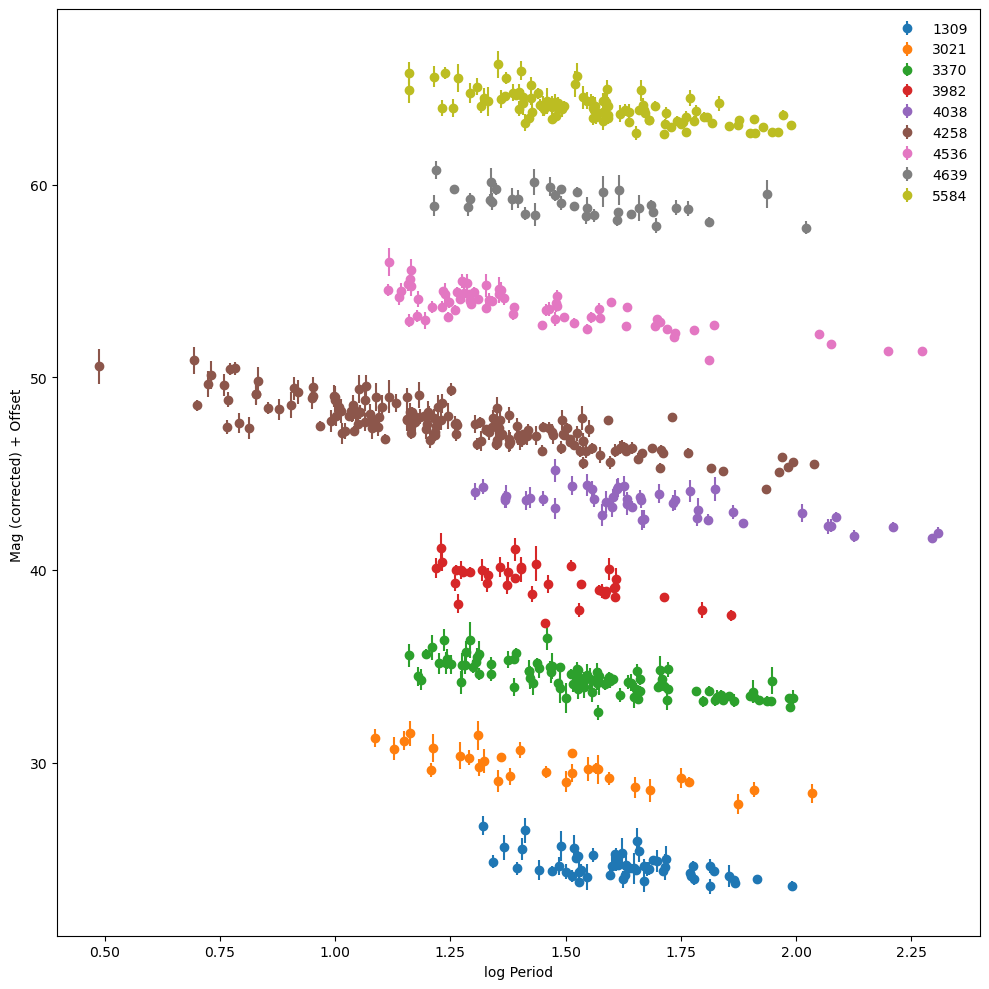

In [284]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+5*i, yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


In [325]:
def riess_mag(mod_i,mod_4258,zp_W,b,logP):
   
    model_mag = mod_i - mod_4258 + zp_W + b*logP
    
    return model_mag

def log_likelihood(params):  ## Using chi-squared, as in the paper
    
    mod_i = params[:-2]
    mod_4258 = params[-3]
    zp_W = params[-2]
    b = params[-1]
    
    ceph.select(4536)
    l_4536 = np.sum((riess_mag(mod_i[0],mod_4258,zp_W,b,ceph.logP)-ceph.mobs)**2/(2*ceph.sigma**2))
    
    ceph.select(4639)
    l_4639 = np.sum((riess_mag(mod_i[1],mod_4258,zp_W,b,ceph.logP)-ceph.mobs)**2/(2*ceph.sigma**2))
    
    ceph.select(3370)
    l_3370 = np.sum((riess_mag(mod_i[2],mod_4258,zp_W,b,ceph.logP)-ceph.mobs)**2/(2*ceph.sigma**2))

    ceph.select(3982)
    l_3982 = np.sum((riess_mag(mod_i[3],mod_4258,zp_W,b,ceph.logP)-ceph.mobs)**2/(2*ceph.sigma**2))
    
    ceph.select(3021)
    l_3021 = np.sum((riess_mag(mod_i[4],mod_4258,zp_W,b,ceph.logP)-ceph.mobs)**2/(2*ceph.sigma**2))
    
    ceph.select(1309)
    l_1309 = np.sum((riess_mag(mod_i[5],mod_4258,zp_W,b,ceph.logP)-ceph.mobs)**2/(2*ceph.sigma**2))
    
    ceph.select(5584)
    l_5584 = np.sum((riess_mag(mod_i[6],mod_4258,zp_W,b,ceph.logP)-ceph.mobs)**2/(2*ceph.sigma**2))
    
    ceph.select(4038)
    l_4038 = np.sum((riess_mag(mod_i[7],mod_4258,zp_W,b,ceph.logP)-ceph.mobs)**2/(2*ceph.sigma**2))
    
    ceph.select(4258)
    l_4258 = np.sum((riess_mag(mod_i[8],mod_4258,zp_W,b,ceph.logP)-ceph.mobs)**2/(2*ceph.sigma**2))
    
    return l_4536 + l_4639 + l_3370 + l_3982 + l_3021 + l_1309 + l_5584 + l_4038 + l_4258

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

In [326]:

from scipy.stats import uniform, norm

def log_prior(params):
    
    mod_i = params[:-2]
    mod_4258 = params[-3]
    zp_W = params[-2]
    b = params[-1]
    
    ## Distance modulus for each galaxy
    
    ## Going to cut off because I'm getting weird answers - no mod distance differences in the paper are larger than 4 
    
  #  if (mod_i[0]>4) or (mod_i[1]>4) or (mod_i[2]>4) or\
  #  (mod_i[3]>4) or (mod_i[4]>4) or (mod_i[5]>4) or\
  #  (mod_i[6]>4) or (mod_i[7]>4) or (mod_i[8]>4):
   #     return -np.inf
    
   # else:
    p_mod_4536 = norm.pdf(mod_i[0],loc=5*np.log10(4.22e9*z['4536'])-5) ## Definition of distance modulus, parsecs to reshift 
    p_mod_4639 = norm.pdf(mod_i[1],loc=5*np.log10(4.22e9*z['4639'])-5)
    p_mod_3370 = norm.pdf(mod_i[2],loc=5*np.log10(4.22e9*z['3370'])-5)
    p_mod_3982 = norm.pdf(mod_i[3],loc=5*np.log10(4.22e9*z['3982'])-5)
    p_mod_3021 = norm.pdf(mod_i[4],loc=5*np.log10(4.22e9*z['3021'])-5)
    p_mod_1309 = norm.pdf(mod_i[5],loc=5*np.log10(4.22e9*z['1309'])-5)
    p_mod_5584 = norm.pdf(mod_i[6],loc=5*np.log10(4.22e9*z['5584'])-5)
    p_mod_4038 = norm.pdf(mod_i[7],loc=5*np.log10(4.22e9*z['4038'])-5)
    p_mod_4258 = norm.pdf(mod_i[8],loc=5*np.log10(4.22e9*z['4258'])-5) 

    ## p_W - intercept of period-luminosity equation, by eye looks like ~30, expect random scatter around this
    p_zp_W = norm.pdf(zp_W,loc=30)

    ## b - slope of period-luminosity equation, by eye looks like ~-2.5, expect random scatter around this
    p_b =  norm.pdf(b,loc=-2.5)

    return np.log(p_mod_4536*p_mod_4639*p_mod_3370*p_mod_3982*p_mod_3021*p_mod_1309*p_mod_5584*p_mod_4038*p_mod_4258*p_zp_W*p_b)

In [319]:
5*np.log10(z['3021']*4.22e9)-5

31.681377849784752

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [327]:
def log_posterior(params):
    log_like = log_likelihood(params)
    log_prior_var = log_prior(params)
    log_posterior = log_like + log_prior_var
    return log_posterior

z = ceph.redshifts
n_walkers = 22
n_dim = 11

## initial mod_diff guesses come from table 2 in Riess; initial p_W, b guesses come from by-eye fit
p0 = np.array([30,31,32,31,32,32,31,31,30,31,-2]) + np.mean(ceph.sigma)*np.random.randn(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior)#, kwargs=kwargs) ## From emcee_full_example
state = sampler.run_mcmc(p0, 3000) 
sampler.reset()                    
                                  
sampler.run_mcmc(state, 15000, progress=True,skip_initial_state_check=True);

/tmp/ipykernel_90551/4253772238.py:36: RuntimeWarning: divide by zero encountered in log
  return np.log(p_mod_4536*p_mod_4639*p_mod_3370*p_mod_3982*p_mod_3021*p_mod_1309*p_mod_5584*p_mod_4038*p_mod_4258*p_zp_W*p_b)
100%|█████████████████████████████████████| 15000/15000 [05:22<00:00, 46.58it/s]


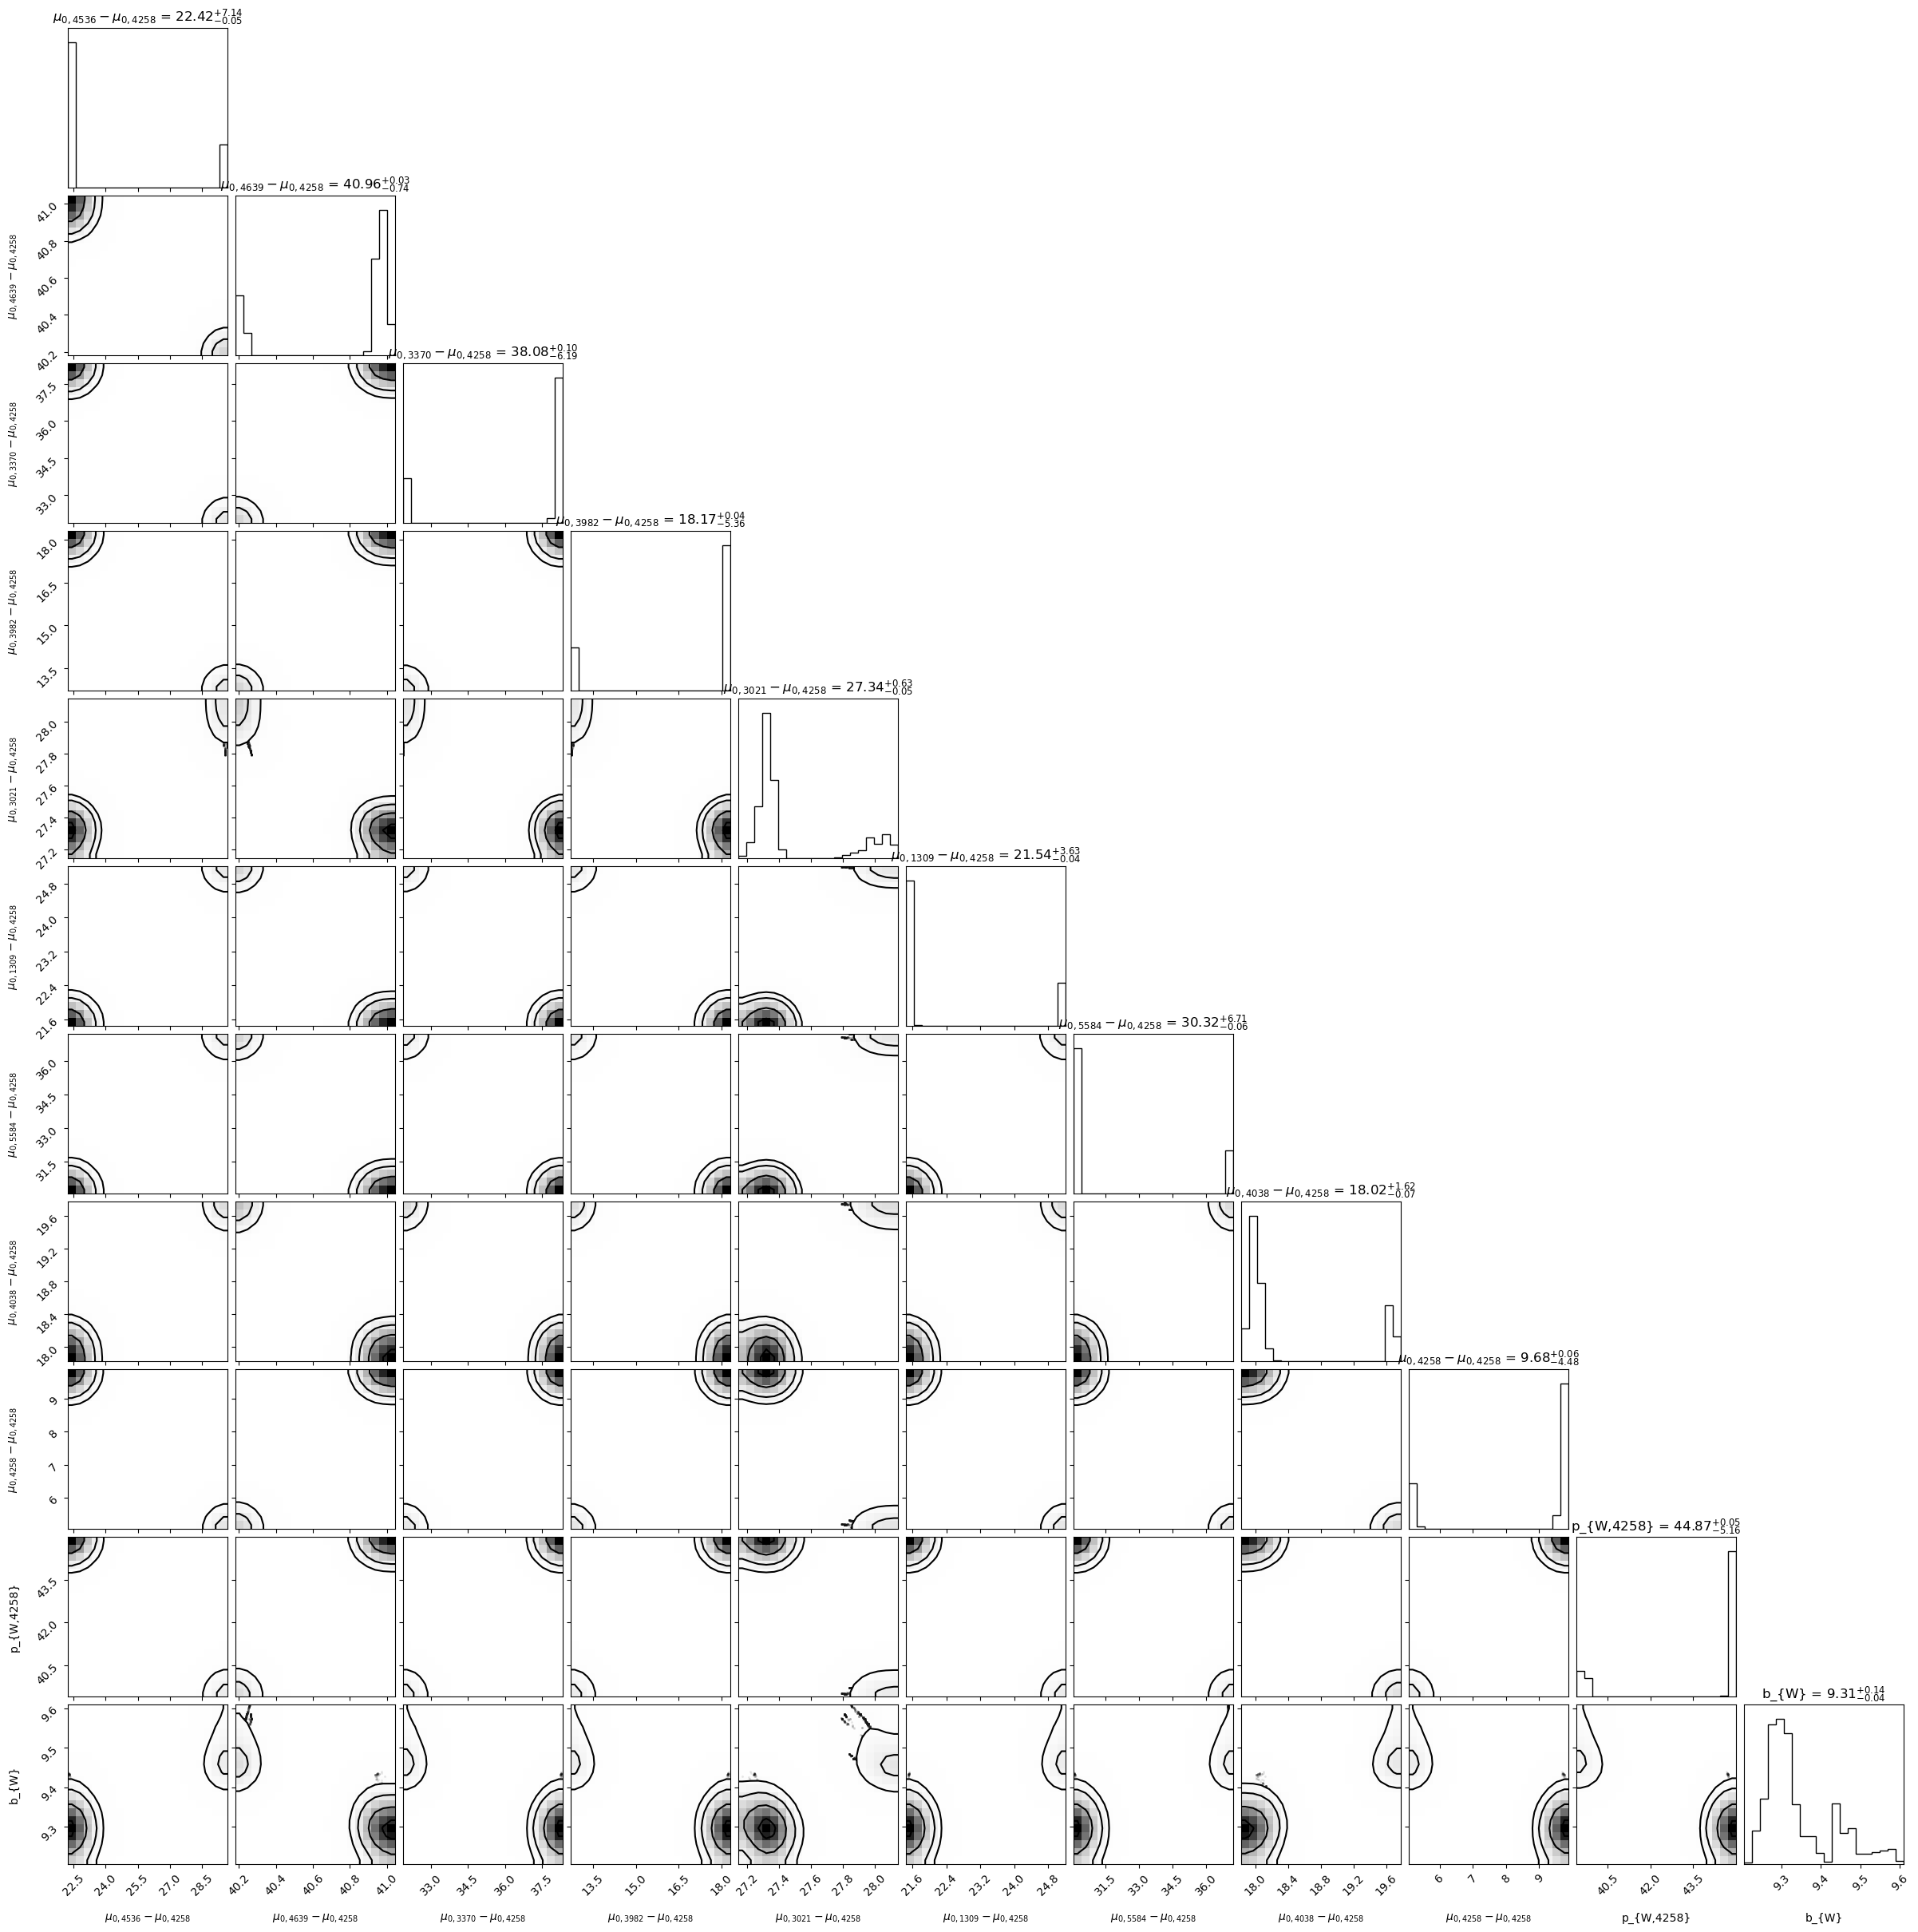

In [328]:
## Show that the posterior is reasonable by generating a corner plot with the corner package. 


sample = sampler.chain
sample_corner = sampler.chain[:, 3000:, :].reshape(-1, n_dim)
labels= [r'$\mu_{0,4536}-\mu_{0,4258}$',r'$\mu_{0,4639}-\mu_{0,4258}$',r'$\mu_{0,3370}-\mu_{0,4258}$',
         r'$\mu_{0,3982}-\mu_{0,4258}$',r'$\mu_{0,3021}-\mu_{0,4258}$',r'$\mu_{0,1309}-\mu_{0,4258}$',
         r'$\mu_{0,5584}-\mu_{0,4258}$',r'$\mu_{0,4038}-\mu_{0,4258}$',r'$\mu_{0,4258}-\mu_{0,4258}$',r'p_{W,4258}','b_{W}']
fig = corner.corner(sample_corner[3000::10,:], plot_contours=True, show_titles=True, smooth=2, labels=labels)
fig.savefig('uhoh.pdf')

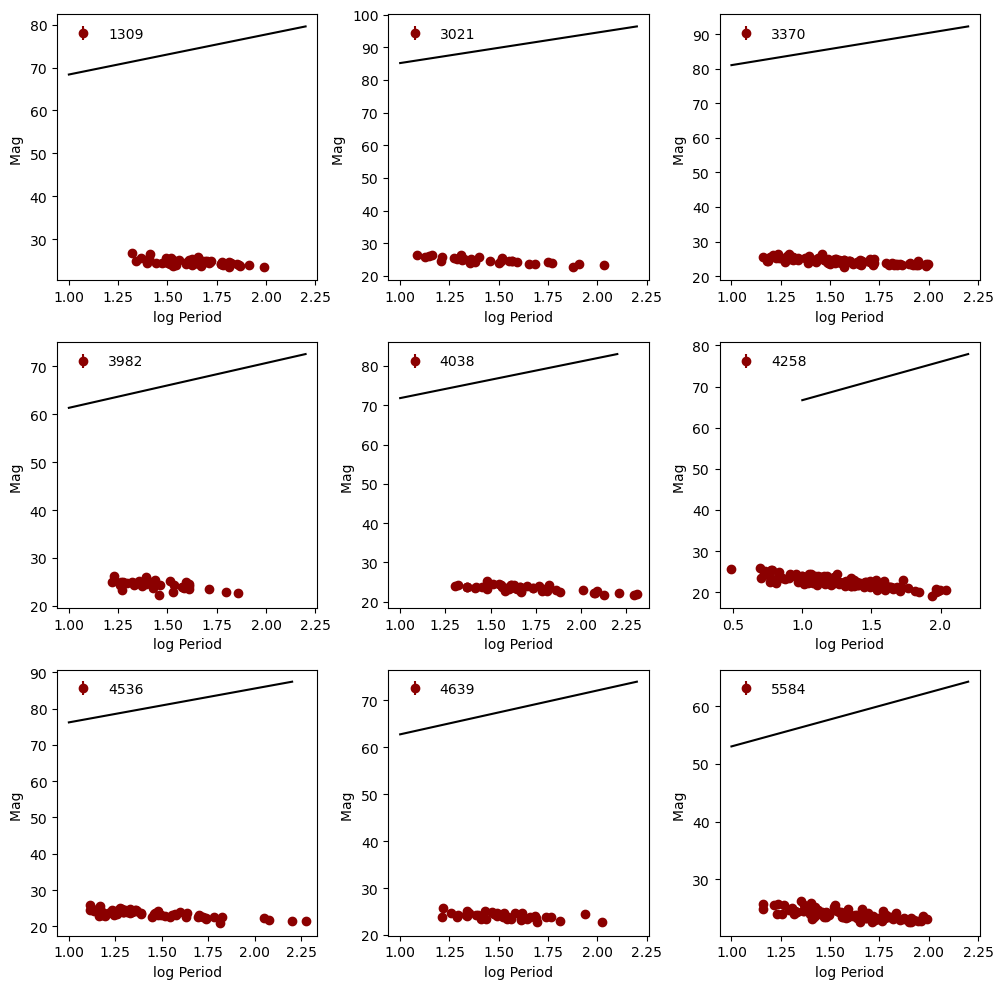

In [330]:
%matplotlib inline
fig, axs = plt.subplots(3,3,figsize=(10, 10))

for i, ID in enumerate(hosts):
    
    ## set up axis
    ax = axs[np.unravel_index(i, (3,3))]
    
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o', label=ID, color='darkred')
    ax.plot(np.linspace(1,2.2,100),riess_mag(np.mean(sample[:,3000::10,i]),np.mean(sample[:,3000::10,-3]),
                                             np.mean(sample[:,3000::10,-2]),np.mean(sample[:,3000::10,-1]),np.linspace(1,2.2,100)),color='black')
    ax.legend(frameon=False)
    ax.set_xlabel('log Period')
    ax.set_ylabel('Mag ')
    #ax.set_ylim(28,18)
    #ax.set_xlim(1,2.2)
    #ax.plot(logP,)
    

fig.tight_layout()


# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and then re-express equation 4 using a substitution of equation 3.

## Write that expression down.

## $\log H_0 = \frac{m^{0}_{v,4258}-\mu_{0,4258}+5 a_{v} + 25}{5}$

### and

## $m^{0}_{v,i} = (\mu_{0,i}-\mu_{0,4258}) + m^{0}_{v,4258}$

### so

## $\log H_0 = \frac{(m^{0}_{v,i}+\mu_{0,i})+5 a_{v} + 25}{5}$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [344]:
m0plus5a = np.array([15.147,16.040,16.545,15.953,16.699,16.768,16.274,15.901])
mu_0 = []

for i in range(8):
    mu_0_i = np.mean(sample[:,3000::10,i]) ## Excluding n4258
    mu_0.append(mu_0_i)


log_H0 = (m0plus5a+mu_0+25)/5
log_H0

## This is wrong!

array([12.8358393 , 16.36735168, 15.65048208, 11.58263303, 13.83543345,
       12.82430735, 14.62239298, 11.85689067])

### 